<a href="https://colab.research.google.com/github/AxelBadouel/machinelearningcourse/blob/main/myversion_of_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

creiamo il dataset divide da solo tra traininge test xk ha già come test integrado essendo un dataset di torch vison ma noi dobbiamo creare il validation
4

In [ ]:
list=[[] for _ in range(10)]
list[0].append('martina')
print(list)

[['martina'], [], [], [], [], [], [], [], [], []]


In [13]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import numpy as np
import random
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory


import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split  # Importa strumenti per il caricamento e la suddivisione dei dati


In [4]:
# Definisce la trasformazione da applicare alle immagini:
# converte le immagini in tensori e le normalizza con media e deviazione standard predefinite per CIFAR-100
transform = transforms.Compose([
    transforms.ToTensor(),  # Converte l'immagine PIL in un tensore
    transforms.Normalize((0.5071, 0.4867, 0.4408),  # Media per ciascun canale RGB
                         (0.2675, 0.2565, 0.2761))  # Deviazione standard per ciascun canale RGB
])

# Scarica il dataset CIFAR-100 (train e test) se non è già presente nella directory indicata
train_full = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

generator = torch.Generator().manual_seed(42) # Per fare in modo che lo random_split avvenga in  modo deterministico e quindi riproducibile

# Suddivide il dataset di training in due parti: 90% per il training, 10% per la validazione
train_size = int(0.9 * len(train_full))  # Calcola la dimensione del set di training (90% di 50000 = 45000)
valid_size = len(train_full) - train_size  # Il resto va nel set di validazione (10% = 5000)
train_set, valid_set = random_split(train_full, [train_size, valid_size], generator)  # Esegue la divisione















caricato il modello verificare se è correto


In [7]:
dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
#dino_model = timm.create_model('vit_small_patch16_224_dino', pretrained=True)
in_features = dino_model.num_features  # Ottiene il numero di feature in uscita dal backbone
dino_model.head = nn.Linear(in_features, 100)

# Imposta il dispositivo di calcolo: usa la GPU se disponibile, altrimenti la CPU
# e trasferisce il modello DINO sul dispositivo scelto per allenamento o inferenza
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dino_model.to(device)




Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_featu

In [5]:
print(dino_model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_featu

classicatore finale in load(): model.head ---> come output 100 layer

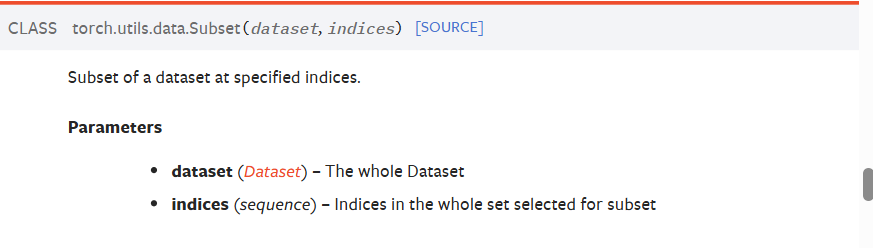

https://docs.pytorch.org/docs/stable/data.html control + f 'Subset(dataset, indices)'


In [29]:
def make_shards(dataset, num_clients, tot_classes, iid=True, num_classes_per_client=2):

    # if iid:
    # IID: mescola casualmente tutti gli indici e li divide equamente tra i client
    indexPerm= np.random.permutation(len(dataset))  # Mescola gli indici dei dati
    shard_size = len(dataset) // num_clients  # Calcola la dimensione di ogni shard
    client_indices = []  # Lista vuota per gli indici di ciascun client

    for i in range(num_clients): #range(num_clients) include lo zero e va fino a num_clients - 1.
        start = i * shard_size  # Inizio dello shard per il client i
        end = start + shard_size  # Fine dello shard per il client i
        #COMMENTO:
        # Ottieni il blocco di indici per il client i
          # prende gli indici dall'array np.random.permutation(len(dataset)) dalla posizione
          # start alla posizione end-1
        shard = indexPerm[start:end]

        # Aggiungi lo shard alla lista
        client_indices.append(shard)
        print(f"Client indices: {client_indices[i]}")

    # else:
    #   #creo una lista dove ogni entata ci sono gli indici del dataset che hanno quella label
    #   indici_classe= [[] for _ in range(tot_classes)]
    #   for idx in range(len(dataset)):
    #       _, label = dataset[idx]  # Estrae solo la label
    #       #in CIFAR-100 le label possono sembrare parole ma nel dataset CIFAR100 di PyTorch,
    #       #ogni immagine è associata internamente a un indice intero da 0 a 99, che rappresenta l'ultima classe
    #       indici_classe[label].append(idx)
    #       # Mischia gli indici all'interno di ogni classe (shuffle)

    #       for classe in range(tot_classes):
    #         np.random.shuffle(indici_classe[classe])  # Mischia direttamente gli indici all'interno della lista della classe
    #       # Con shuffle, i dati all'interno di class_indices[i] vengono rimescolati in modo casuale
    #       # NON viene creata una nuova lista, ma la lista stessa viene modificata
    #       print(f"Client indices: {client_indices[i]}")
    # #------------------------------------

    # Lista vuota in cui andremo a memorizzare i sotto-dataset per ciascun client
    subset_list = []
    # Ora, per ogni gruppo di indici che rappresenta i dati per ciascun client,
    # creiamo un 'Subset' che rappresenta il sotto-dataset di quel client.
    for indices in client_indices:
    # Crea un Subset del dataset originale utilizzando gli indici specificati per un client.
    # Ogni 'subset' contiene solo i dati corrispondenti agli 'indices' specificati.
      subset = Subset(dataset, indices)  # Crea il sotto-dataset per ciascun client

      # Aggiungi il 'subset' appena creato alla lista subset_list
      # subset_list diventa una lista di sotto-dataset per ogni client
      subset_list.append(subset)

# dataset = range(100)
# num_clients = 6
# tot_classes = 10
# make_shards(dataset, num_clients, tot_classes)

Client indices: [27 13 26 62 77 45 82 66 94 99 57 75 23 90 44 50]
Client indices: [81 47 96  5 49  1 25 17 40 59 29 35  8 46  6 68]
Client indices: [55 93  7 84 63 78  4 91 58 60 33 64 34 20 97 67]
Client indices: [41 15 18 89 10 30 71 51  9 24 31 98 37 73 56 48]
Client indices: [52 54 11 39 70 28 61 53 74 88 86 42 14 32  2 76]
Client indices: [22 95 38  3 72 21 80 85 69 65 36 43  0 79 12 16]
Subset list: [27 13 26 62 77 45 82 66 94 99 57 75 23 90 44 50]


In [34]:
def non_iid_indices(dataset, num_clients, Nc=2, num_classes=7):
    """
    Restituisce una lista di liste di indici del dataset per ogni client,
    seguendo una distribuzione non-IID con Nc classi per client.

    Args:
        dataset: dataset PyTorch (con __getitem__ che restituisce (image, label))
        num_clients: numero di client
        Nc: numero di classi per client
        num_classes: numero totale di classi nel dataset
        seed: seme per la riproducibilità

    Returns:
        client_indices: lista di liste, ogni sotto-lista contiene gli indici assegnati a un client
    """
    seed=42
    random.seed(seed)
    np.random.seed(seed)

    # Step 1: Organizza gli indici per classe
    class_indices = [[] for _ in range(num_classes)]
    print(class_indices)
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        class_indices[label].append(idx)

    # Shuffle degli indici dentro ogni classe (modifica in-place)
    for cls_idxs in class_indices:
        random.shuffle(cls_idxs)  # Mescola direttamente gli elementi della lista

    # Step 2: Assegna Nc classi diverse a ogni client
    client_indices = [[] for _ in range(num_clients)]


    # DIZIONARIO CHE INDICA Quante volte ogni classe deve essere assegnata, approssimativamente
    class_assignments = {i: 0 for i in range(num_classes)}




    for client_id in range(num_clients):
      # Se finiti i pool, rimescola (per garantire che ogni classe venga usata abbastanza)
      if len(class_pool) < Nc:
          class_pool = all_class_ids.copy()
          random.shuffle(class_pool)

      # Seleziona Nc classi non ancora troppo usate
      selected_classes = []
      while len(selected_classes) < Nc and class_pool:
          cls = class_pool.pop()
          selected_classes.append(cls)
          class_assignments[cls] += 1

      # Determina quanti esempi per questo client (circa bilanciato)
      total_per_client = len(dataset) // num_clients
      samples_per_class = total_per_client // Nc

      for cls in selected_classes:
          selected_indices = class_indices[cls][:samples_per_class]
          class_indices[cls] = class_indices[cls][samples_per_class:]  # Rimuove gli usati
          client_indices[client_id].extend(selected_indices)

    return client_indices


dataset = range(100)
num_clients = 6
non_iid_indices(dataset, num_clients)


[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


TypeError: cannot unpack non-iterable int object